# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [1]:
# Install the required libraries
!pip install prophet


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Importing plotly failed. Interactive plots will not work.


## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [3]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

/var/folders/vm/f6pvbz7s47x42fysq4vxsyk40000gn/T/ipykernel_25035/1669825240.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [4]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


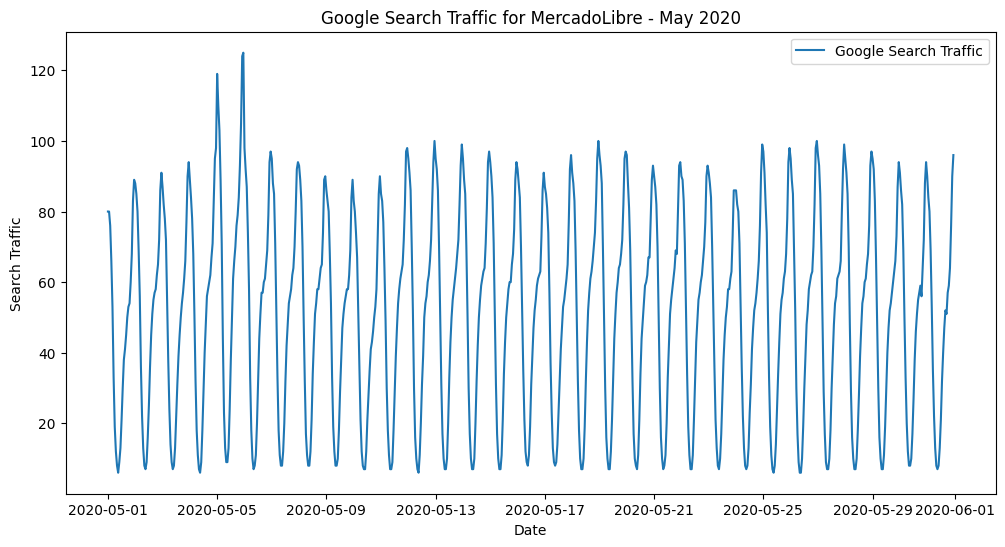

In [5]:
# Slice the DataFrame to just the month of May 2020
df_may_2020 = df_mercado_trends.loc['2020-05-01':'2020-05-31']

# Plot to visualize the data for May 2020
plt.figure(figsize=(12, 6))
plt.plot(df_may_2020, label='Google Search Traffic')
plt.title('Google Search Traffic for MercadoLibre - May 2020')
plt.xlabel('Date')
plt.ylabel('Search Traffic')
plt.legend()
plt.show()

#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [6]:
# Calculate the sum of the total search traffic for May 2020
traffic_may_2020 = df_may_2020.sum()

# View the traffic_may_2020 value
print(traffic_may_2020)

Search Trends    38181
dtype: int64


In [7]:
# Calcluate the monhtly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
median_monthly_traffic = df_mercado_trends.resample('M').sum().median()


# View the median_monthly_traffic value
print(median_monthly_traffic)

Search Trends    35172.5
dtype: float64


/var/folders/vm/f6pvbz7s47x42fysq4vxsyk40000gn/T/ipykernel_25035/1855421131.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  median_monthly_traffic = df_mercado_trends.resample('M').sum().median()


In [8]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
traffic_may_2020/median_monthly_traffic

Search Trends    1.085536
dtype: float64

##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** 
Yes, the Google search traffic increased during May 2020, the month MercadoLibre released its financial results.
From the calculations:
The total search traffic for May 2020 was 38,181.
The median monthly search traffic across all months was 35,172.5.
The ratio of May 2020 traffic to the median monthly traffic was 1.0855, indicating an 8.55% increase in search traffic.
This suggests that the release of MercadoLibre's financial results correlated with a rise in Google search interest for the company.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


In [9]:
# Calcluate the monhtly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
median_monthly_traffic = df_mercado_trends.resample('M').sum().median()


# View the median_monthly_traffic value
print(median_monthly_traffic)

Search Trends    35172.5
dtype: float64


/var/folders/vm/f6pvbz7s47x42fysq4vxsyk40000gn/T/ipykernel_25035/1855421131.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  median_monthly_traffic = df_mercado_trends.resample('M').sum().median()


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

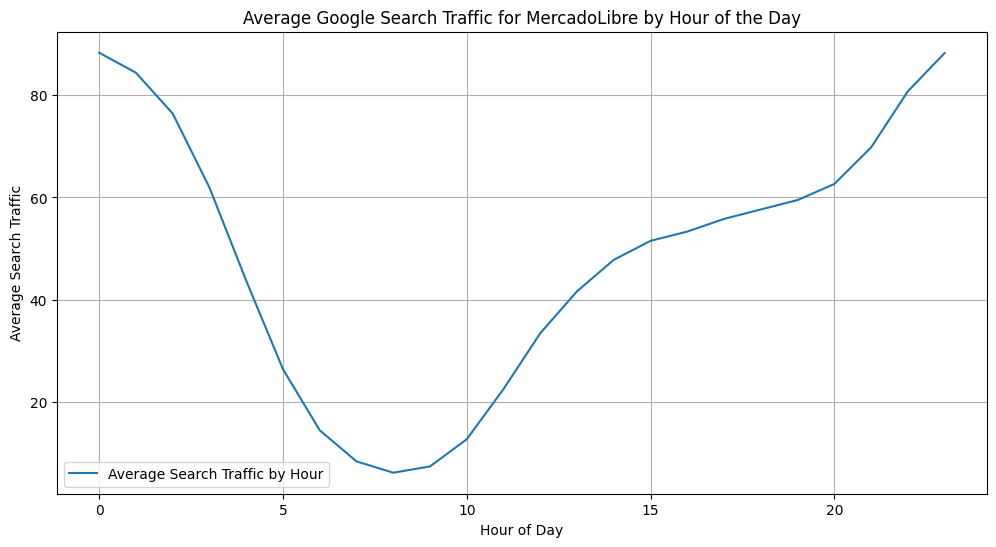

In [10]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`
hourly_traffic = df_mercado_trends.groupby(df_mercado_trends.index.hour).mean()
plt.figure(figsize=(12, 6))
plt.plot(hourly_traffic, label='Average Search Traffic by Hour')
plt.title('Average Google Search Traffic for MercadoLibre by Hour of the Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Search Traffic')
plt.legend()
plt.grid(True)
plt.show()

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

In [11]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
weekly_traffic = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().day).mean()


#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

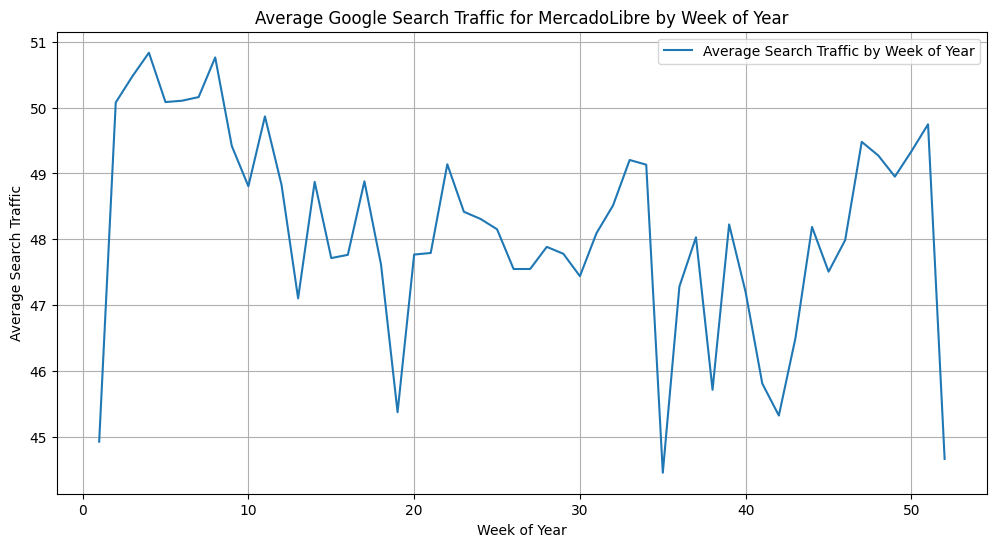

In [12]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
weekly_traffic_by_week = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week).mean()
plt.figure(figsize=(12, 6))
plt.plot(weekly_traffic_by_week, label='Average Search Traffic by Week of Year')
plt.title('Average Google Search Traffic for MercadoLibre by Week of Year')
plt.xlabel('Week of Year')
plt.ylabel('Average Search Traffic')
plt.legend()
plt.grid(True)
plt.show()

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:** A little bit inversed relationshop of time based trends in the data.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [13]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


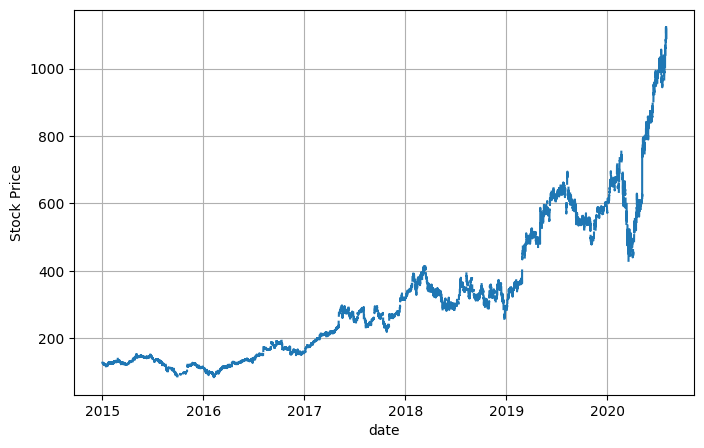

In [14]:
# Visualize the closing price of the df_mercado_stock DataFrame
df_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
)
plt.figure(figsize=(8, 5))
plt.plot(df_stock.index, df_stock["close"])
plt.xlabel("date")
plt.ylabel("Stock Price")
plt.grid()
plt.show()

In [15]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
df_mercado = pd.concat([df_mercado_stock, df_mercado_trends], axis=1).dropna()

# View the first and last five rows of the DataFrame

print(df_mercado.head())
print(df_mercado.tail())

                      close  Search Trends
2016-06-01 09:00:00  135.16            6.0
2016-06-01 10:00:00  136.63           12.0
2016-06-01 11:00:00  136.56           22.0
2016-06-01 12:00:00  136.42           33.0
2016-06-01 13:00:00  136.10           40.0
                        close  Search Trends
2020-07-31 11:00:00  1105.780           20.0
2020-07-31 12:00:00  1087.925           32.0
2020-07-31 13:00:00  1095.800           41.0
2020-07-31 14:00:00  1110.650           47.0
2020-07-31 15:00:00  1122.510           53.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [16]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
df_mercado.index = pd.to_datetime(df_mercado.index)

# View the first and last five rows of first_half_2020 DataFrame
first_half_2020 = df_mercado.loc['2020-01':'2020-06']
print(first_half_2020.head())
print(first_half_2020.tail())

                       close  Search Trends
2020-01-02 09:00:00  601.085            9.0
2020-01-02 10:00:00  601.290           14.0
2020-01-02 11:00:00  615.410           25.0
2020-01-02 12:00:00  611.400           37.0
2020-01-02 13:00:00  611.830           50.0
                      close  Search Trends
2020-06-30 11:00:00  976.17           17.0
2020-06-30 12:00:00  977.50           27.0
2020-06-30 13:00:00  973.23           37.0
2020-06-30 14:00:00  976.50           45.0
2020-06-30 15:00:00  984.93           51.0


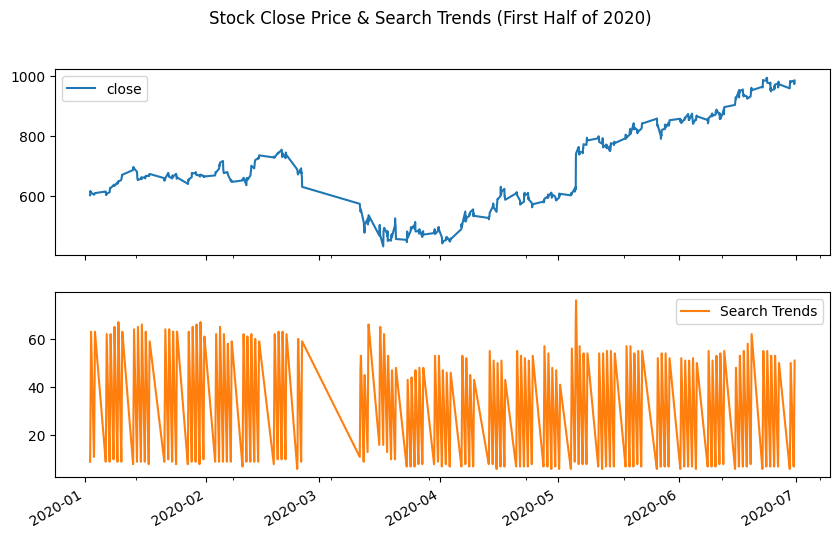

In [114]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`
first_half_2020.plot(subplots=True, figsize=(10, 6), title="Stock Close Price & Search Trends (First Half of 2020)")
plt.show()

##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** Both time series show a potential correlation, with search trends spiking during major stock movements. While the stock price follows a clearer upward trend, search interest remains volatile but aligns with key price changes.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [17]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
df_mercado['Lagged Search Trends'] = df_mercado['Search Trends'].shift(1)



In [18]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
df_mercado['Stock Return'] = df_mercado['close'].pct_change()
df_mercado['Stock Volatility'] = df_mercado['Stock Return'].rolling(window=4).std()



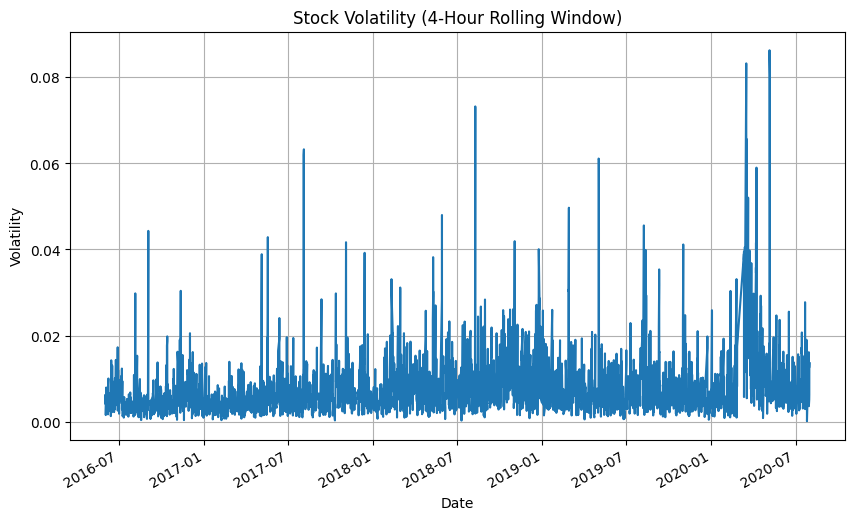

In [19]:
# Visualize the stock volatility
df_mercado['Stock Volatility'].plot(figsize=(10, 6), title='Stock Volatility (4-Hour Rolling Window)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid()
plt.show()


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [20]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
df_mercado['Hourly Stock Return'] = df_mercado['close'].pct_change()



In [21]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
print(df_mercado.head())
print(df_mercado.tail())

                      close  Search Trends  Lagged Search Trends  \
2016-06-01 09:00:00  135.16            6.0                   NaN   
2016-06-01 10:00:00  136.63           12.0                   6.0   
2016-06-01 11:00:00  136.56           22.0                  12.0   
2016-06-01 12:00:00  136.42           33.0                  22.0   
2016-06-01 13:00:00  136.10           40.0                  33.0   

                     Stock Return  Stock Volatility  Hourly Stock Return  
2016-06-01 09:00:00           NaN               NaN                  NaN  
2016-06-01 10:00:00      0.010876               NaN             0.010876  
2016-06-01 11:00:00     -0.000512               NaN            -0.000512  
2016-06-01 12:00:00     -0.001025               NaN            -0.001025  
2016-06-01 13:00:00     -0.002346          0.006134            -0.002346  
                        close  Search Trends  Lagged Search Trends  \
2020-07-31 11:00:00  1105.780           20.0                  11.0   
2

#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [22]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
correlation_table = df_mercado[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()
print(correlation_table)


                      Stock Volatility  Lagged Search Trends  \
Stock Volatility              1.000000             -0.148938   
Lagged Search Trends         -0.148938              1.000000   
Hourly Stock Return           0.061424              0.017929   

                      Hourly Stock Return  
Stock Volatility                 0.061424  
Lagged Search Trends             0.017929  
Hourly Stock Return              1.000000  


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** The low correlation values across all pairs suggest that there is no strong predictable relationship between lagged search traffic, stock volatility, and stock returns. 

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [33]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
df_mercado_trends_reset = df_mercado_trends.reset_index()


# Label the columns ds and y so that the syntax is recognized by Prophet
df_mercado_prophet = df_mercado_trends_reset.rename(columns={'Date': 'ds', 'Search Trends': 'y'})


# Drop an NaN values from the prophet_df DataFrame
df_mercado_prophet = df_mercado_prophet.dropna()


# View the first and last five rows of the mercado_prophet_df DataFrame
print(df_mercado_prophet.head())
print(df_mercado_prophet.tail())

                   ds   y
0 2016-06-01 00:00:00  97
1 2016-06-01 01:00:00  92
2 2016-06-01 02:00:00  76
3 2016-06-01 03:00:00  60
4 2016-06-01 04:00:00  38
                       ds   y
37101 2020-09-07 20:00:00  71
37102 2020-09-07 21:00:00  83
37103 2020-09-07 22:00:00  96
37104 2020-09-07 23:00:00  97
37105 2020-09-08 00:00:00  96


In [43]:
# Call the Prophet function, store as an object
from prophet import Prophet

model = Prophet()



In [44]:
# Fit the time-series model.
model.fit(df_mercado_prophet)


21:44:10 - cmdstanpy - INFO - Chain [1] start processing
21:44:16 - cmdstanpy - INFO - Chain [1] done processing


In [83]:
# Create a future dataframe for the next 2000 hours
future_mercado_trends = model.make_future_dataframe(periods=2000, freq='H')

/opt/anaconda3/envs/dev/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


In [84]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
forecast_mercado_trends = model.predict(future_mercado_trends)


# View the last five rows of the future_mercado_trends DataFrame
print(forecast_mercado_trends[['ds',  'yhat', 'yhat_lower', 'yhat_upper']].tail())

                       ds       yhat  yhat_lower  yhat_upper
39101 2020-11-30 04:00:00  39.283272   30.576558   48.324607
39102 2020-11-30 05:00:00  23.812065   14.748711   32.264745
39103 2020-11-30 06:00:00  11.846318    2.783072   20.207585
39104 2020-11-30 07:00:00   4.574080   -3.787188   12.664431
39105 2020-11-30 08:00:00   2.379109   -6.058913   10.895712


In [85]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_mercado_trends = model.predict(future_mercado_trends)


# Display the first five rows of the forecast_mercado_trends DataFrame
print(forecast_mercado_trends[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())


                   ds       yhat  yhat_lower  yhat_upper
0 2016-06-01 00:00:00  89.558555   80.697217   98.423979
1 2016-06-01 01:00:00  86.005386   78.237367   94.610862
2 2016-06-01 02:00:00  75.682942   67.175676   84.146034
3 2016-06-01 03:00:00  60.416789   52.164443   68.699382
4 2016-06-01 04:00:00  43.302997   35.067422   51.488306


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

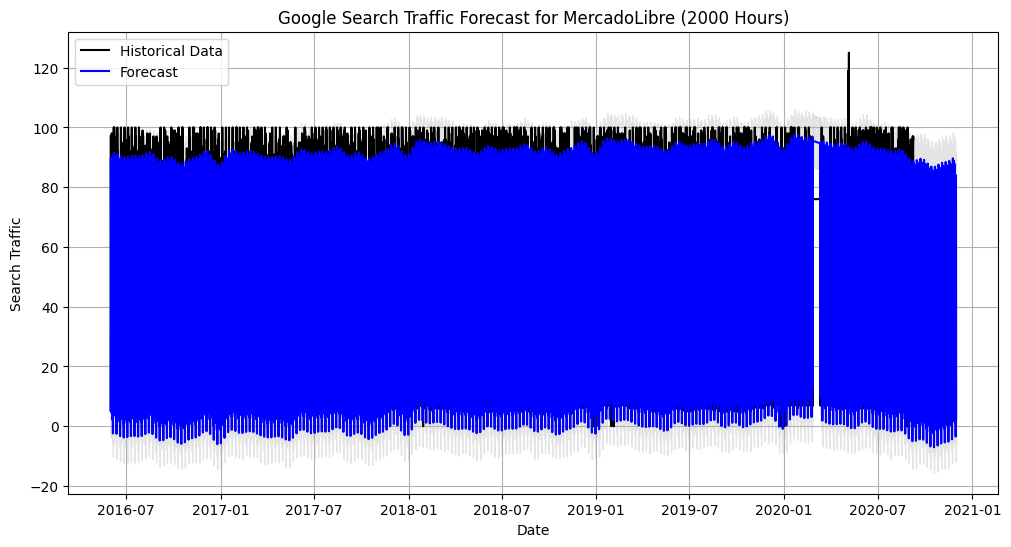

In [87]:
# Plot the Prophet predictions for the Mercado trends data
plt.figure(figsize=(12, 6))
plt.plot(df_mercado_prophet['ds'], df_mercado_prophet['y'], label='Historical Data', color='black')
plt.plot(forecast_mercado_trends['ds'], forecast_mercado_trends['yhat'], label='Forecast', color='blue')
plt.fill_between(forecast_mercado_trends['ds'], forecast_mercado_trends['yhat_lower'], forecast_mercado_trends['yhat_upper'], color='gray', alpha=0.2)
plt.title('Google Search Traffic Forecast for MercadoLibre (2000 Hours)')
plt.xlabel('Date')
plt.ylabel('Search Traffic')
plt.legend()
plt.grid(True)
plt.show()

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:** The near-term forecast for the popularity of MercadoLibre shows predicted search traffic trends, with potential increases or decreases, while the shaded area indicates forecast uncertainty.


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [88]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends.set_index('ds', inplace=True)


# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']].head()


,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.558555,80.697217,98.423979
2016-06-01 01:00:00,86.005386,78.237367,94.610862
2016-06-01 02:00:00,75.682942,67.175676,84.146034
2016-06-01 03:00:00,60.416789,52.164443,68.699382
2016-06-01 04:00:00,43.302997,35.067422,51.488306


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

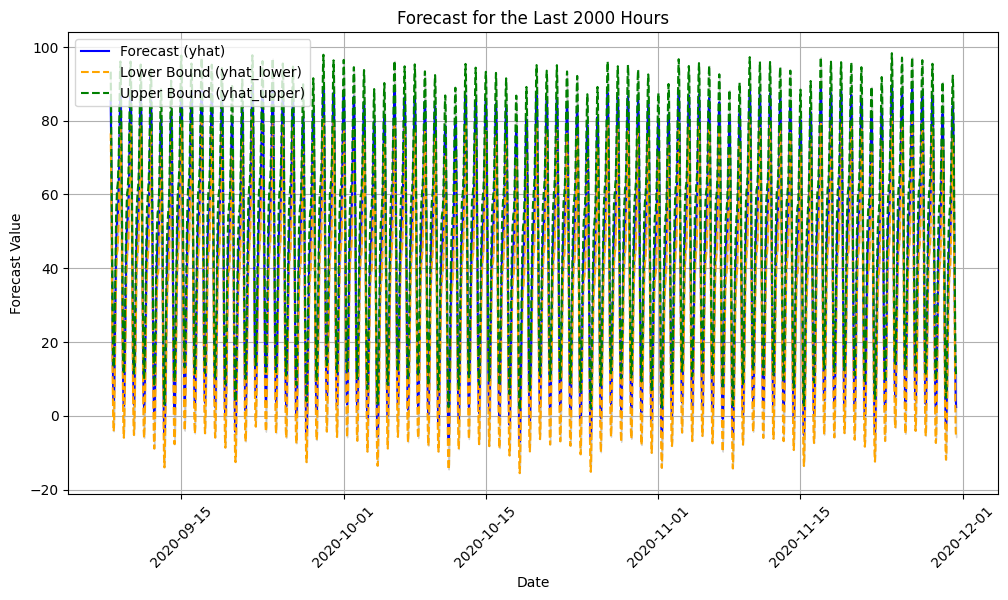

In [89]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours

forecast_mercado_trends = forecast_mercado_trends.reset_index()
forecast_mercado_trends['ds'] = pd.to_datetime(forecast_mercado_trends['ds'])

# Filter the last 2000 hours
last_2000_hours = forecast_mercado_trends.tail(2000)

# Plot the forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(last_2000_hours['ds'], last_2000_hours['yhat'], label='Forecast (yhat)', color='blue')
plt.plot(last_2000_hours['ds'], last_2000_hours['yhat_lower'], label='Lower Bound (yhat_lower)', color='orange', linestyle='dashed')
plt.plot(last_2000_hours['ds'], last_2000_hours['yhat_upper'], label='Upper Bound (yhat_upper)', color='green', linestyle='dashed')
plt.fill_between(last_2000_hours['ds'], 
                 last_2000_hours['yhat_lower'], 
                 last_2000_hours['yhat_upper'], 
                 color='gray', alpha=0.3)

plt.title('Forecast for the Last 2000 Hours')
plt.xlabel('Date')
plt.ylabel('Forecast Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(loc='upper left')  # Move legend to upper left for clarity
plt.grid(True)
plt.show()

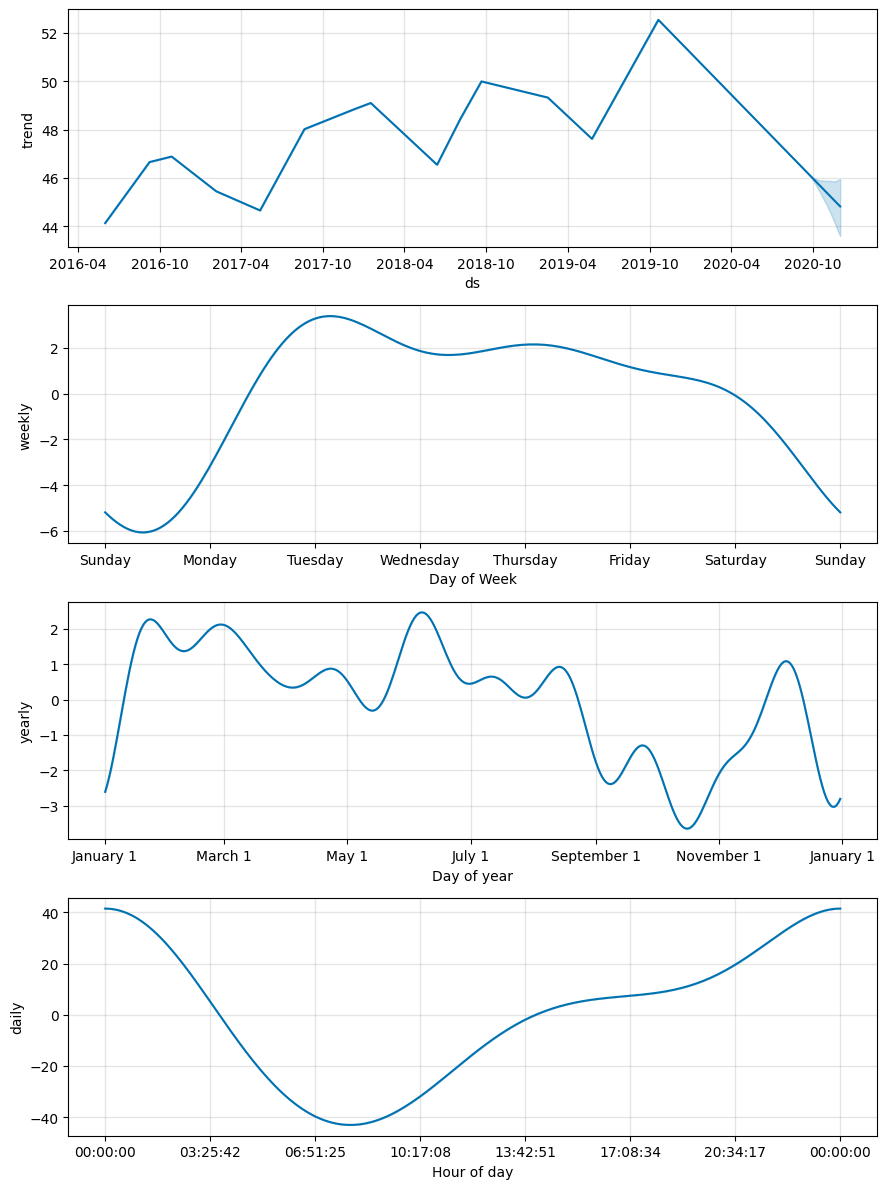

In [91]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends.reset_index(inplace=True)

# Use the plot_components function to visualize the forecast results
# for the forecast_mercado_trends DataFrame
model.plot_components(forecast_mercado_trends)
plt.show()

##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** The bottom graph (daily seasonality) shows the highest point around midnight, meaning that search traffic is highest at that time.

**Question:** Which day of week gets the most search traffic?
   
**Answer:** The weekly seasonality graph indicates that Tuesday has the highest search traffic.

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** The yearly seasonality graph shows that the lowest search traffic occurs just after the beginning of the year, likely in early January.
